In [3]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


**1.** 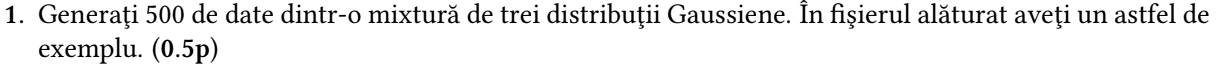 

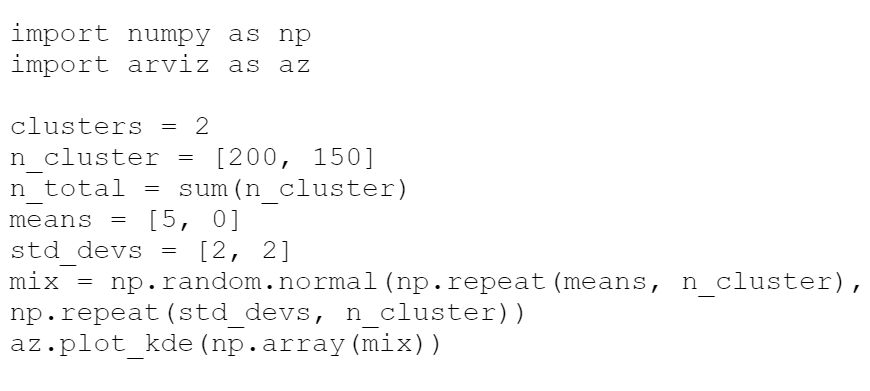

* creare distributie mixata cu 3 componente, fiecare avand o medie si o dev standard specifica

<Axes: >

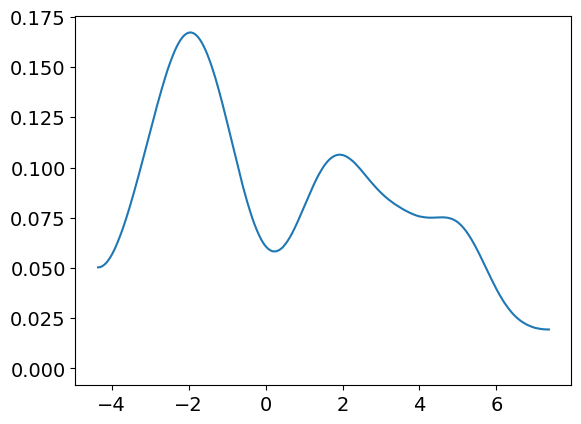

In [38]:
clusters = 2 
n_cluster = [250, 150, 100] # nr de puncte de date pt fiecare cluster; in total, 500
n_total = sum(n_cluster)
means = [-2, 2, 5] # media pt fiecare cluster
std_devs = [1, 1, 1] # dev standard pt fiecare cluster

#mix=cum ar arata setul de date daca am amesteca datele provenite din cele 3 distributii
mix = np.random.normal(np.repeat(means, n_cluster),np.repeat(std_devs, n_cluster)) 
az.plot_kde(np.array(mix))

**2.** 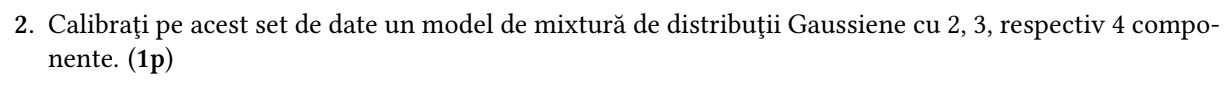

In [39]:
clusters = [2, 3, 4]
models = []
idatas = []
for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(cluster)) # distribuție Dirichlet pentru a modela proporțiile fiecărui cluster în mixtură. 
        #Aceasta asigură că suma proporțiilor este întotdeauna 1.

        means = pm.Normal('means', mu=np.linspace(mix.min(), mix.max(), cluster),sigma=10, shape=cluster, transform=pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sigma=10)
        # folosesc NormalMixture ca sa rulexze mai rpd ptc 
        # nu includ explicit variabila z, ci in probabilitati conditionale
        # facute automat de functia NM
        y = pm.NormalMixture('y', w=p, mu=means, sigma=sd, observed=mix)
        idata = pm.sample(1000, tune=2000, target_accept=0.9, random_seed=123, return_inferencedata=True)
    idatas.append(idata)
    models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 24 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 384 divergences after tuning. Increase `target_accept` or reparameterize.


**3.** 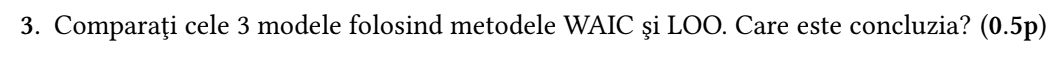

- folosind WAIC = widely applicable information criterion
- Un scor WAIC mai mic indică o performanță mai bună a modelului. Este folosit pentru a alege între modele alternative, iar un model cu un scor WAIC mai mic este considerat mai preferat.

In [40]:
[pm.compute_log_likelihood(idatas[i], model=models[i]) for i in range(3)]

[Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data]

   rank    elpd_waic    p_waic  elpd_diff        weight         se        dse  \
3     0  2333.879389  5.889493   0.000000  5.904936e-01  25.263355   0.000000   
4     1  2334.666559  6.289289   0.787170  4.095059e-01  22.535862   0.677883   
2     2  2395.313380  4.121095  61.433991  4.297909e-07  25.262936  13.717401   

   warning     scale  
3    False  deviance  
4    False  deviance  
2    False  deviance  


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

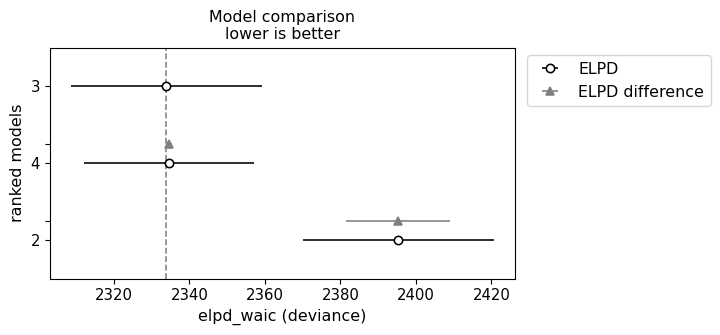

In [41]:
comp_waic = az.compare(dict(zip([str(c) for c in clusters], idatas)),method='BB-pseudo-BMA', ic="waic", scale="deviance")
print(comp_waic)
az.plot_compare(comp_waic)

   rank     elpd_loo     p_loo  elpd_diff        weight         se        dse  \
3     0  2333.895091  5.897343   0.000000  5.965294e-01  25.219729   0.000000   
4     1  2334.688489  6.300254   0.793399  4.034704e-01  23.621503   0.677722   
2     2  2395.324675  4.126743  61.429584  1.366870e-07  25.187926  13.717559   

   warning     scale  
3    False  deviance  
4    False  deviance  
2    False  deviance  


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_loo (deviance)', ylabel='ranked models'>

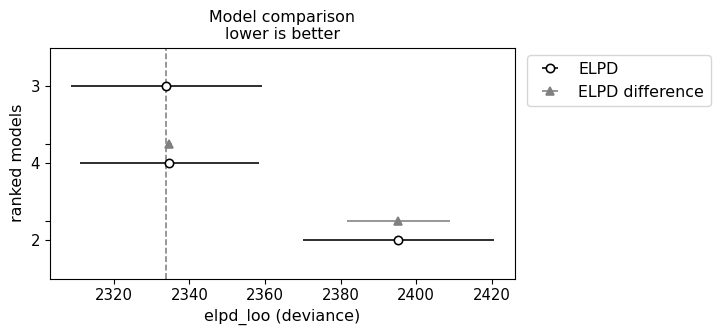

In [42]:
comp_loo = az.compare(dict(zip([str(c) for c in clusters], idatas)),method='BB-pseudo-BMA', ic="loo", scale="deviance")
print(comp_loo)
az.plot_compare(comp_loo)

Este clar că (pe datele generate, dar asta se vede și din modul în care arată distribuția lor), modelul de ordinul 3 este cel mai bun.